In [41]:
import os
import warnings
import polars as pl
import pandas as pd
import numpy as np
import scorecardpy as sc
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns



In [27]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# 1. Define Paths
csv_path = "/home/thathsara/AI_Project/credit-risk/accepted_2007_to_2018Q4.csv.gz"
parquet_path = "/home/thathsara/AI_Project/credit-risk/lending_club_data.parquet"

print(f"Streaming conversion from {csv_path} to {parquet_path}...")

Streaming conversion from /home/thathsara/AI_Project/credit-risk/accepted_2007_to_2018Q4.csv.gz to /home/thathsara/AI_Project/credit-risk/lending_club_data.parquet...


In [3]:
# 2. Define the Lazy Query
# We use 'scan_csv' instead of 'read_csv'. This creates a plan, doesn't load data.
q = (
    pl.scan_csv(csv_path, ignore_errors=True)
    .filter(
        # Apply the filter inside the stream so we don't process useless rows
        pl.col("loan_status").is_in(['Fully Paid', 'Charged Off'])
    )
    .select([
        # specific columns to keep file size small
        "loan_amnt", "term", "int_rate", "installment", "grade", "sub_grade",
        "emp_title", "emp_length", "home_ownership", "annual_inc", 
        "verification_status", "issue_d", "loan_status", "purpose", "dti", 
        "earliest_cr_line", "open_acc", "pub_rec", "revol_bal", "revol_util", 
        "total_acc", "initial_list_status", "application_type", "mort_acc", 
        "pub_rec_bankruptcies", "addr_state"
    ])
)

In [4]:
# 3. Stream to Parquet
# 'sink_parquet' is the magic function. It processes the file in batches.
# It will keep RAM usage very low (usually < 1GB).
q.sink_parquet(parquet_path)

print("Success! Conversion complete without RAM spike.")

Success! Conversion complete without RAM spike.


In [21]:
# Load the new Parquet file
df = pd.read_parquet("/home/thathsara/AI_Project/credit-risk/lending_club_data.parquet")

In [22]:
# Create Target
df['target'] = np.where(df['loan_status'] == 'Charged Off', 1, 0)

In [23]:
print(f"Row Count: {df.shape[0]}")
print(f"Default Rate: {df['target'].mean():.2%}")

Row Count: 1345310
Default Rate: 19.96%


In [24]:
df.head(5)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,addr_state,target
0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,...,0.0,2765.0,29.7,13.0,w,Individual,1.0,0.0,PA,0
1,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,...,0.0,21470.0,19.2,38.0,w,Individual,4.0,0.0,SD,0
2,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,...,0.0,7869.0,56.2,18.0,w,Joint App,5.0,0.0,IL,0
3,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,...,0.0,21929.0,64.5,35.0,w,Individual,6.0,0.0,PA,0
4,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,...,0.0,8822.0,68.4,6.0,w,Individual,0.0,0.0,GA,0


Feature Engineering

In [25]:
# 1. Convert to datetime objects 
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# 2. Calculate Credit History Length 
# We calculate exact calendar months instead of dividing by days.
months_diff = (
    (df['issue_d'].dt.year - df['earliest_cr_line'].dt.year) * 12 + 
    (df['issue_d'].dt.month - df['earliest_cr_line'].dt.month)
)

# 3. Create the final feature (Years)
df['credit_hist_years'] = months_diff / 12

# 4. Clean up (Fill NaNs with 0, ensure no negative values)
df['credit_hist_years'] = df['credit_hist_years'].fillna(0)
df.loc[df['credit_hist_years'] < 0, 'credit_hist_years'] = 0

print(f"Created 'credit_hist_years'. Min: {df['credit_hist_years'].min()}, Max: {df['credit_hist_years'].max()}")

Created 'credit_hist_years'. Min: 3.0, Max: 83.25


In [28]:
# 1. Define the specific list of candidates
# We exclude raw dates and text, keeping only numeric/categorical signals
sel_cols = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 
    'purpose', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 
    'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 
    'credit_hist_years', 'target'
]

# Create a specific dataframe for modeling
df_model = df[sel_cols].copy()

# 2. Automated IV Calculation
# This effectively performs "Univariate Analysis" on every column at once.
print("Calculating Information Value (IV)")
iv_df = sc.iv(df_model, y="target")

# 3. Display the Results
print("\n--- Top 10 Strongest Predictors ---")
print(iv_df.head(10))

# 4. Check specific variables
print("\n--- Specific Variable Strength ---")
print(iv_df[iv_df['variable'].isin(['annual_inc', 'dti', 'credit_hist_years'])])

Calculating Information Value (IV)

--- Top 10 Strongest Predictors ---
               variable  info_value
7           installment    0.651764
6              int_rate    0.526346
16                grade    0.461824
1             revol_bal    0.265463
13           annual_inc    0.196275
3                  term    0.174415
2                   dti    0.102773
18            loan_amnt    0.084336
0   verification_status    0.055835
5              mort_acc    0.045362

--- Specific Variable Strength ---
             variable  info_value
13         annual_inc    0.196275
2                 dti    0.102773
12  credit_hist_years    0.014581


In [29]:
# Select Variables based on IV
# We keep variables with IV > 0.02 (Standard Industry Threshold)

selected_vars = iv_df[iv_df['info_value'] > 0.02]['variable'].tolist()

# Add target back if it got lost
if 'target' not in selected_vars:
    selected_vars.append('target')

print(f"Selected {len(selected_vars)} strong predictors.")

Selected 13 strong predictors.


In [30]:
# Create Bins (The Logic)
# This generates the "rules" for grouping (e.g., "Income < 50k" vs "Income > 50k")

print("Generating Binning Rules...")
bins = sc.woebin(df_model[selected_vars], y="target")

Generating Binning Rules...
[INFO] creating woe binning ...


/home/thathsara/miniforge3/envs/ds_lab/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/home/thathsara/miniforge3/envs/ds_lab/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/home/thathsara/miniforge3/envs/ds_lab/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: U

Binning on 1345310 rows and 13 columns in 00:00:46


In [31]:
# Transform Data (The conversion)
# Convert raw values (e.g., "60000") into WoE values (e.g., "0.15")
print("Converting raw data to WoE values...")
df_woe = sc.woebin_ply(df_model[selected_vars], bins)

Converting raw data to WoE values...
[INFO] converting into woe values ...
Woe transformating on 1345310 rows and 12 columns in 00:00:36


In [32]:
# 5. Train/Test Split
# We split *after* binning but *before* modeling
X_woe = df_woe.drop(columns=['target'])
y_woe = df_woe['target']

X_train, X_test, y_train, y_test = train_test_split(X_woe, y_woe, test_size=0.3, random_state=42)

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape:  {X_test.shape}")


Train Shape: (941717, 12)
Test Shape:  (403593, 12)


Train LightGBM & Evaluate

In [34]:
#Initialize the LightGBM Model
# We use standard parameters for binary classification
print("Training LightGBM Model...")
model = lgb.LGBMClassifier(
    n_estimators=1000,      # Number of trees
    learning_rate=0.05,     # Learn slowly (better generalization)
    max_depth=5,            # Shallow trees (prevents overfitting)
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

Training LightGBM Model...


In [35]:
#Train
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 188333, number of negative: 753384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 941717, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199989 -> initscore=-1.386363
[LightGBM] [Info] Start training from score -1.386363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [36]:
#Predict Probabilities (Not just 0/1, but the % risk)
# We want the probability of being "Bad" (Class 1)
y_prob = model.predict_proba(X_test)[:, 1]

In [37]:
#Calculate AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc:.4f}")

AUC Score: 0.7100


In [38]:
#Calculate KS Statistic (The Banking Standard)
# KS = Max(True Positive Rate - False Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ks_statistic = np.max(tpr - fpr)

print(f"KS Statistic: {ks_statistic:.4f}")

KS Statistic: 0.3053


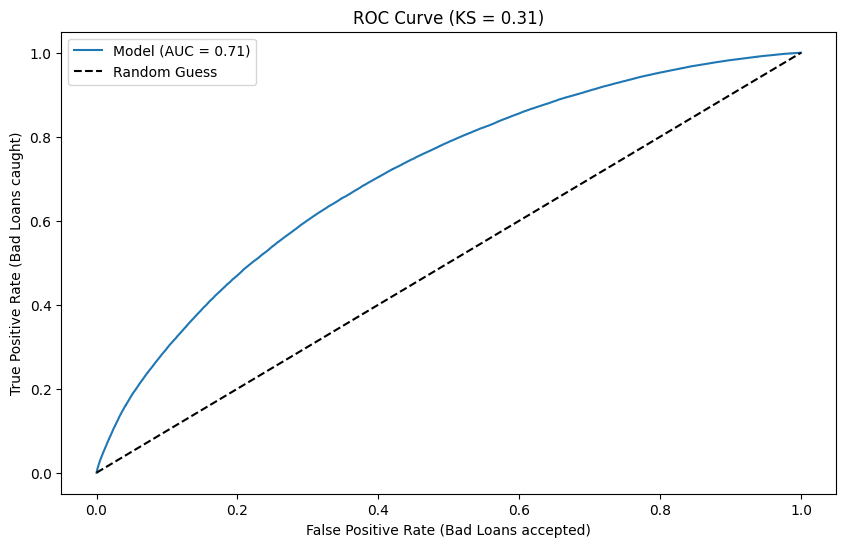

In [39]:
#Visualize the Separation
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (Bad Loans accepted)')
plt.ylabel('True Positive Rate (Bad Loans caught)')
plt.title(f'ROC Curve (KS = {ks_statistic:.2f})')
plt.legend()
plt.show()

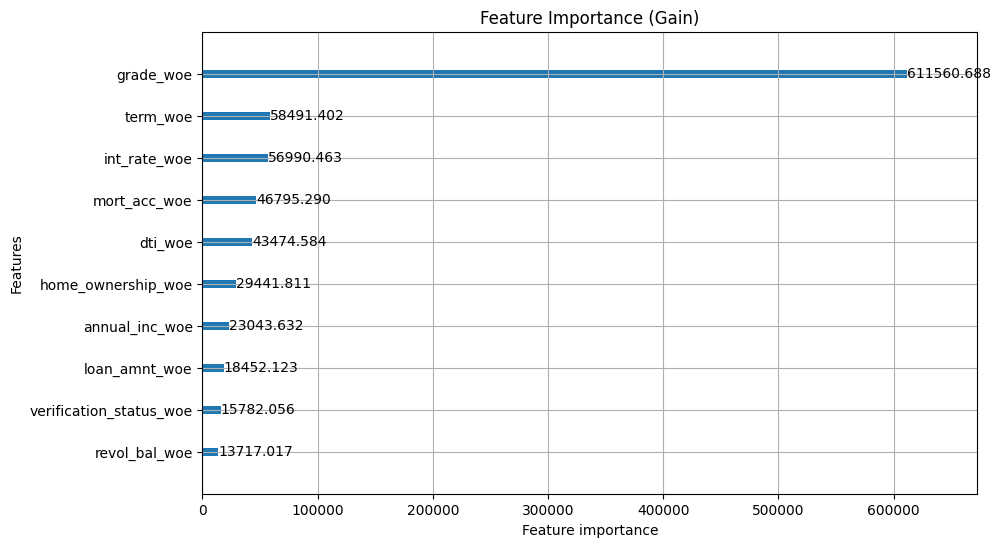

In [40]:
#Feature Importance (Sanity Check)
lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance (Gain)")
plt.show()

Credit Scorecard (The Product)

In [42]:
# Calibration Configuration (FICO Style)
# These are standard industry assumptions
target_score = 600
target_odds = 50  # e.g., 50:1 odds
pdo = 20          # Points to Double the Odds

# Calculate Factor and Offset
factor = pdo / np.log(2)
offset = target_score - (factor * np.log(target_odds))

In [43]:
#Calculate Scores
# Odds = P(Good) / P(Bad) = (1 - p) / p
# We add a tiny epsilon (1e-10) to avoid dividing by zero
odds = (1 - y_prob) / (y_prob + 1e-10)
scores = offset + (factor * np.log(odds))

# 4. Clamp Scores to Range (300 - 850)
scores = np.clip(scores, 300, 850)

# Add scores to a temporary dataframe for visualization
df_results = X_test.copy()
df_results['score'] = scores
df_results['actual_target'] = y_test

print(f"Min Score: {scores.min():.0f}")
print(f"Max Score: {scores.max():.0f}")
print(f"Avg Score: {scores.mean():.0f}")

Min Score: 455
Max Score: 653
Avg Score: 533


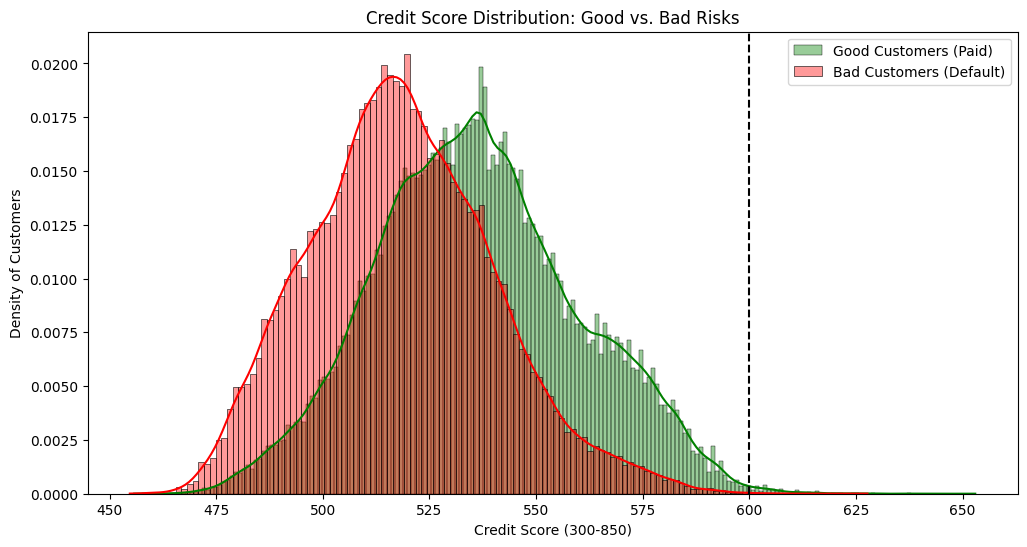

In [44]:

# Visualize the "Product"
plt.figure(figsize=(12, 6))

# Histogram for Good Customers (Target = 0)
sns.histplot(
    data=df_results[df_results['actual_target'] == 0], 
    x='score', 
    color='green', 
    label='Good Customers (Paid)', 
    kde=True, 
    stat="density",
    alpha=0.4
)

# Histogram for Bad Customers (Target = 1)
sns.histplot(
    data=df_results[df_results['actual_target'] == 1], 
    x='score', 
    color='red', 
    label='Bad Customers (Default)', 
    kde=True, 
    stat="density",
    alpha=0.4
)

plt.title('Credit Score Distribution: Good vs. Bad Risks')
plt.xlabel('Credit Score (300-850)')
plt.ylabel('Density of Customers')
plt.legend()
plt.axvline(x=600, color='black', linestyle='--', label='Cutoff')
plt.show()

In [45]:
import joblib

# 1. Save the Model
joblib.dump(model, 'lgb_credit_model.pkl')

# 2. Save the Binning Rules (Critical for preprocessing new data)
# We use 'pickle' for the scorecardpy bins dictionary
import pickle
with open('woe_bins.pkl', 'wb') as f:
    pickle.dump(bins, f)

print("Model and Binning Rules saved successfully.")

Model and Binning Rules saved successfully.
